In [189]:
import pandas as pd
import pm4py
import psycopg2
import collections
import graphviz

### Importing Data from the created XES file

In [185]:
from pm4py.objects.log.importer.xes import importer as xes_importer

#can be changed to LINE_BY_LINE for better performance
variant = xes_importer.Variants.ITERPARSE

parameters = {variant.value.Parameters.TIMESTAMP_SORT: True,
            variant.value.Parameters.MAX_TRACES: 100000}

log = xes_importer.apply('data/simple_event_log.xes', variant = variant, parameters = parameters)

KeyboardInterrupt: 

### Pandas Conversion & Selection of Assessments

In [ ]:
import pm4py.objects.conversion.log.converter as converter

log_pd = converter.apply(log, variant = converter.Variants.TO_DATA_FRAME)

In [ ]:
log_pd

,time:timestamp,concept:name,assessment,site,case:concept:name
0,2014-04-21,register,NaN,NaN,648183_DDD_2014J
1,2014-09-06,interact,NaN,814218.0,648183_DDD_2014J
2,2014-09-06,interact,NaN,813701.0,648183_DDD_2014J
3,2014-09-06,interact,NaN,813936.0,648183_DDD_2014J
4,2014-09-06,interact,NaN,813933.0,648183_DDD_2014J
...,...,...,...,...,...
3686611,2015-02-20,interact,NaN,883169.0,357851_FFF_2014J
3686612,2015-02-20,interact,NaN,882545.0,357851_FFF_2014J
3686613,2015-02-20,interact,NaN,882537.0,357851_FFF_2014J
3686614,2015-02-20,interact,NaN,941543.0,357851_FFF_2014J


### Calculating the Activity Profile

In [ ]:
activity_profile = log_pd.groupby("case:concept:name")["concept:name"].apply(list)
activity_profile = activity_profile.reset_index()

dummy = list(activity_profile["concept:name"].apply(lambda x : collections.Counter(x)))
dummy = pd.DataFrame(dummy)
dummy["case:concept:name"] = activity_profile["case:concept:name"]
activity_profile = dummy

activity_profile = activity_profile.fillna(0)

In [ ]:
activity_profile

,register,interact,submitAssessment,dropped,case:concept:name
0,1.0,466.0,7.0,0.0,100561_DDD_2014J
1,1.0,440.0,5.0,0.0,100788_CCC_2014J
2,1.0,662.0,5.0,0.0,101116_AAA_2014J
3,1.0,0.0,0.0,1.0,101187_DDD_2014J
4,1.0,239.0,1.0,0.0,101217_FFF_2014J
...,...,...,...,...,...
11254,1.0,93.0,5.0,0.0,98842_BBB_2014J
11255,1.0,692.0,6.0,0.0,99075_DDD_2014J
11256,1.0,110.0,3.0,1.0,99088_BBB_2014J
11257,1.0,52.0,0.0,1.0,99609_DDD_2014J


### Performance Profile

In [ ]:
performance_profile = log_pd.groupby("case:concept:name")["time:timestamp"].apply(list)
performance_profile = performance_profile.reset_index()

#total case duration
performance_profile["duration"] = performance_profile["time:timestamp"].apply(lambda x: ( x[-1]-x[0] ).days )
#number of events
performance_profile["events"] = performance_profile["time:timestamp"].apply(lambda x: len(x))

#dropping the dummy column
performance_profile.drop("time:timestamp",axis=1,inplace = True)

In [ ]:
performance_profile


,case:concept:name,duration,events
0,100561_DDD_2014J,278,474
1,100788_CCC_2014J,347,446
2,101116_AAA_2014J,349,668
3,101187_DDD_2014J,83,2
4,101217_FFF_2014J,224,241
...,...,...,...
11254,98842_BBB_2014J,262,99
11255,99075_DDD_2014J,318,699
11256,99088_BBB_2014J,162,115
11257,99609_DDD_2014J,178,54


### Connection to Postgres
Taking information about VLE environment as well as about student grades

In [ ]:
query_grades = """

SELECT DISTINCT
	registration.code_module,
	assessments.code_presentation,
	student_assessment.id_student,
	assessments.id_assessment,
	assessments.weight,
	student_assessment.score,
	registration.date_unregistration as still_enrolled
	
FROM student_assessment

JOIN assessments ON student_assessment.id_assessment = assessments.id_assessment

LEFT JOIN registration ON student_assessment.id_student = registration.id_student

WHERE assessments.code_presentation = '2014J' OR assessments.code_presentation = '2014B'

"""

In [ ]:
query_vle = """

SELECT id_site, activity_type
FROM vle
WHERE vle.code_presentation = '2014J' OR vle.code_presentation = '2014B'

"""

In [ ]:
from psycopg2 import Error

try:
    # Connect to an existing database
    connection = psycopg2.connect(user="postgres",
                                  password="thesis1",
                                  host="localhost",
                                  port="5433",
                                  database="OULAD")

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Executing a SQL query
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")

    #getting the SQL info
    cursor.execute(query_grades)
    grade_profile = cursor.fetchall()

    cursor.execute(query_vle)
    vle = cursor.fetchall()


except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if (connection):
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

You are connected to -  ('PostgreSQL 14.2, compiled by Visual C++ build 1914, 64-bit',) 

PostgreSQL connection is closed


In [ ]:
# comes as tuples and needs to be converted to pd
grade_profile = pd.DataFrame(grade_profile, columns = ["code_module","code_presentation","id_student","id_assessment","weight","score","still_enrolled"])
grade_profile["id_assessment"]=pd.to_numeric(grade_profile["id_assessment"])

vle = pd.DataFrame(vle, columns = ["site","activity_type"])

### Grades Profile

In [ ]:
#creating a column mimicking the case:concept:name identifier
def case_id (row, info):
    id= ''
    for i in info:
        id = id +'_'+ str(row[i])
    return id[1:]
keys = ["id_student", "code_module", "code_presentation"]

dummy=[]
for i,rows in grade_profile.iterrows():
    #creating the case_id
    dummy.append ( case_id(rows, keys) )

grade_profile["case:concept:name"] = dummy

In [ ]:
grade_profile["score"] = grade_profile["score"]*grade_profile["weight"]/100

grade_profile = grade_profile[["case:concept:name","score"]]
grade_profile.reset_index(drop=True,inplace=True)

In [ ]:
pd.options.mode.chained_assignment = None

grade_profile["count"] = grade_profile["case:concept:name"].copy()

grade_profile = grade_profile.groupby(["case:concept:name"]).agg({ "score":"sum",
                                                     "count": "count" })

grade_profile.reset_index(inplace = True)
grade_profile.drop(["count"],axis=1, inplace = True)

In [ ]:
grade_profile

,case:concept:name,score
0,100561_DDD_2014J,72.50
1,1006742_FFF_2014B,9.75
2,100788_CCC_2014J,21.93
3,100788_FFF_2014J,21.93
4,101116_AAA_2014J,82.90
...,...,...
16765,992544_CCC_2014B,24.00
16766,996047_EEE_2014B,82.32
16767,99670_FFF_2014B,89.50
16768,99799_BBB_2014B,62.66


### VLE Profile

In [ ]:
vle_profile = log_pd[["case:concept:name","site"]].merge(vle, on = "site")
vle_profile = vle_profile.groupby("case:concept:name")["activity_type"].apply(list)

vle_profile = vle_profile.reset_index()

dummy = list(vle_profile["activity_type"].apply(lambda x : collections.Counter(x)))
dummy = pd.DataFrame(dummy)
dummy["case:concept:name"] = vle_profile["case:concept:name"]
dummy = dummy.fillna(0)
vle_profile = dummy

In [ ]:
vle_profile

,homepage,resource,oucontent,subpage,forumng,externalquiz,oucollaborate,url,quiz,page,glossary,dataplus,ouwiki,htmlactivity,questionnaire,dualpane,repeatactivity,case:concept:name
0,380.0,188.0,196.0,436.0,448.0,88.0,32.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100561_DDD_2014J
1,352.0,256.0,92.0,300.0,208.0,0.0,4.0,92.0,452.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100788_CCC_2014J
2,496.0,92.0,492.0,244.0,1248.0,0.0,0.0,64.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,101116_AAA_2014J
3,124.0,192.0,204.0,260.0,92.0,0.0,24.0,16.0,12.0,12.0,0.0,0.0,4.0,16.0,0.0,0.0,0.0,101217_FFF_2014J
4,32.0,32.0,56.0,32.0,36.0,0.0,4.0,12.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,101279_DDD_2014J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10138,56.0,48.0,80.0,60.0,84.0,0.0,4.0,8.0,28.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,98842_BBB_2014J
10139,368.0,548.0,160.0,984.0,488.0,60.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99075_DDD_2014J
10140,68.0,20.0,248.0,20.0,48.0,0.0,0.0,8.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99088_BBB_2014J
10141,32.0,12.0,56.0,40.0,52.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99609_DDD_2014J


## Merging all profiles together to prepare for K-means clustering

In [ ]:
from functools import reduce

data = [activity_profile, performance_profile, grade_profile, vle_profile]

In [ ]:
data = reduce(lambda  left, right: pd.merge(left, right, on=['case:concept:name'],
                                            how='inner'), data).fillna(0)

In [ ]:
data

,register,interact,submitAssessment,dropped,case:concept:name,duration,events,score,homepage,resource,...,url,quiz,page,glossary,dataplus,ouwiki,htmlactivity,questionnaire,dualpane,repeatactivity
0,1.0,466.0,7.0,0.0,100561_DDD_2014J,278,474,72.50,380.0,188.0,...,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,440.0,5.0,0.0,100788_CCC_2014J,347,446,21.93,352.0,256.0,...,92.0,452.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,662.0,5.0,0.0,101116_AAA_2014J,349,668,82.90,496.0,92.0,...,64.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0
3,1.0,239.0,1.0,0.0,101217_FFF_2014J,224,241,17.00,124.0,192.0,...,16.0,12.0,12.0,0.0,0.0,4.0,16.0,0.0,0.0,0.0
4,1.0,52.0,1.0,0.0,101279_DDD_2014J,181,54,2.75,32.0,32.0,...,12.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9014,1.0,439.0,9.0,0.0,986561_CCC_2014J,406,449,89.40,372.0,212.0,...,24.0,400.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9015,1.0,93.0,5.0,0.0,98842_BBB_2014J,262,99,48.25,56.0,48.0,...,8.0,28.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
9016,1.0,692.0,6.0,0.0,99075_DDD_2014J,318,699,39.55,368.0,548.0,...,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9017,1.0,110.0,3.0,1.0,99088_BBB_2014J,162,115,13.30,68.0,20.0,...,8.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
X = data.drop("case:concept:name",axis=1)

In [ ]:
X = StandardScaler().fit_transform(X)

### Elbow Method for # of Clusters

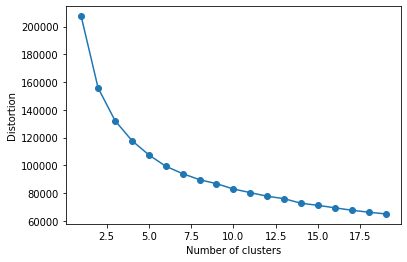

In [ ]:
import matplotlib.pyplot as plt

distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=20,
        random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Applying K-means

In [ ]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=20, 
    random_state=0
)

y_km = km.fit_predict(X)

In [ ]:
data["cluster"] = y_km

### Splitting the EV

In [179]:
data_cl_0 = data[data.cluster == 0]
data_cl_0 = data_cl_0["case:concept:name"]

In [180]:
data_cl_1 = data[data.cluster == 1]
data_cl_1 = data_cl_1["case:concept:name"] 

In [181]:
data_cl_2 = data[data.cluster == 2]
data_cl_2 = data_cl_2["case:concept:name"]

In [182]:
data_cl_3 = data[data.cluster == 3]
data_cl_3 = data_cl_3["case:concept:name"]

In [183]:
print(len(data_cl_0),len(data_cl_1),len(data_cl_2),len(data_cl_3))

4515 2443 470 1591


In [187]:
log_0 = pm4py.filter_event_attribute_values(log, attribute_key="case:concept:name", values = data_cl_0, retain=True, level = "case")
log_1 = pm4py.filter_event_attribute_values(log, attribute_key="case:concept:name", values = data_cl_1, retain=True, level = "case")
log_2 = pm4py.filter_event_attribute_values(log, attribute_key="case:concept:name", values = data_cl_2, retain=True, level = "case")
log_3 = pm4py.filter_event_attribute_values(log, attribute_key="case:concept:name", values = data_cl_3, retain=True, level = "case")

### Heuristi Net

In [193]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

heu_net = heuristics_miner.apply_heu(log_0, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.8})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

InvocationException: GraphViz's executables not found

In [192]:
! conda install graphviz

^C


In [ ]:
heu_net = heuristics_miner.apply_heu(log_1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.8})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [ ]:
heu_net = heuristics_miner.apply_heu(log_2, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.8})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [ ]:
heu_net = heuristics_miner.apply_heu(log_3, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.8})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)